<center>
  <h1>Victorian Era Novelists Authorship Attribution</h1>
  <h2>Progetto di Machine Learning</h2>
  <br>
  <h4>Autori:</h4>
  <p>
    <strong>Elisa Venditti</strong> (matricola 0315909)<br>
    <strong>Francesca Venditti</strong> (matricola 0309669)<br>
  </p>
  <br>
  <h4>Professore:</h4>
  <p>
    <strong>Giorgio Gambosi</strong>
  </p>
  <br>
  <h5>Anno Accademico 2022/2023</h5>
</center>



Il progetto si concentra sullo sviluppo di vari sistemi di machine learning al fine di attribuire l'autore ai testi dell'era vittoriana di cui si compone il dataset utilizzato. Trattandosi di dati testuali si rende necessario un preprocessamento del testo al fine di rendelo adatto alla classificazione. 

Saranno sviluppati diversi modelli e ne saranno analizzate le prestazioni in modo critico, effettuando infine un confronto sulla bontà delle varie soluzioni.

## Analisi del dataset
Come prima cosa, è necessario estrarre i dati dal CSV. I testi saranno analizzati in termini di come si distribuiscono nelle varie classi. Dall'istogramma del dataset si può notare che alcuni autori non hanno nessun item associato.


Dataset di training:



,text,author
0,ou have time to listen i will give you the ent...,1
1,wish for solitude he was twenty years of age a...,1
2,and the skirt blew in perfect freedom about th...,1
3,of san and the rows of shops opposite impresse...,1
4,an hour s walk was as tiresome as three in a s...,1
...,...,...
53673,after surrounding and searching the whole plac...,50
53674,giant who could make a young earthquake or a w...,50
53675,waters of the lake at the bottom of the hill c...,50
53676,fingers and thumb in it exactly as it came out...,50


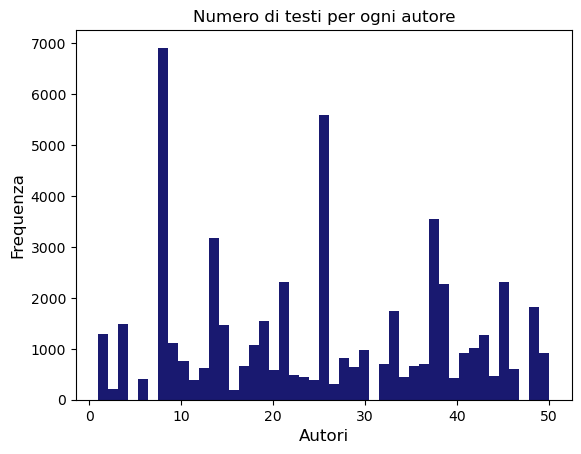

In [101]:
import numpy as np
import pandas as pd
from sklearn import svm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay
# from google.colab import drive
# drive.mount('/content/drive')

import warnings
warnings.filterwarnings('ignore')


# file = "/content/drive/MyDrive/Gungor_2018_VictorianAuthorAttribution_data-train.csv"
file = "C:\\Users\\Utente\\Desktop\\ML\\materiale\\Gungor_2018_VictorianAuthorAttribution_data-train.csv"
df   = pd.read_csv(file, delimiter=',',  encoding='latin-1')
print("Dataset di training:\n")
display(df)


classes = [x for x in df['author'].unique()]
authors = len(classes)


# Istogramma
authors_array = df['author'].to_numpy()
plt.hist(authors_array, bins=authors, color='midnightblue')
plt.xlabel('Autori', fontsize=12)
plt.ylabel('Frequenza',fontsize=12)
plt.title('Numero di testi per ogni autore')
plt.show()

## Riduzione del dataset e campionamento di training set e test set
La riduzione di istanze del dataset è necessaria a causa di problemi computazionali. Mantenendo il dataset con oltre 50.000 istanze, ad esempio, la funzione obiettivo della SVM (primo modello analizzato di seguito) può essere migliorata in tempi accettabili ($<1$ ora) solo fino a 10 iterazioni. 

Viene sfruttata la funzione _train_test_split_ per entrambi i compiti da svolgere:
* per prima cosa si riduce la dimensionalità dell'intero dataset, campionando autore per autore in modo da lasciare inalterata la proporzione di elementi nelle classi;
* si estrae, poi, training set e test set con le proporzioni 70-30.


,text,author
49633,if there too danger threatened they should on ...,45
41139,court for mark you here mr david we could no d...,38
40347,sleeve for to at they have that or which it is...,37
34213,ts â i js d each cloth covers for binding is e...,32
49436,rise into the air with colours waving with the...,45
...,...,...
15685,i had not seen him for many weeks before he sa...,14
40134,present but with eye the past or heedless of t...,37
14694,the mother who provided the tea and other it w...,14
43605,every single officer the warrant and petty off...,39


,text,author
34197,country a wet summer is a very nasty business ...,32
36246,uncle s daughter â that is what has changed he...,33
24958,the achievements of our countrymen and inciden...,23
19163,not to one or of tbe forms just as you or i gr...,18
16759,her carriage and was driving to that her consc...,15
...,...,...
51178,d and u have in china than a iti europe variet...,48
9831,mr for a little m i indulgence the name i have...,8
30329,of expressing himself which made them all wort...,26
34354,looking upon that mother now taking of her sur...,32


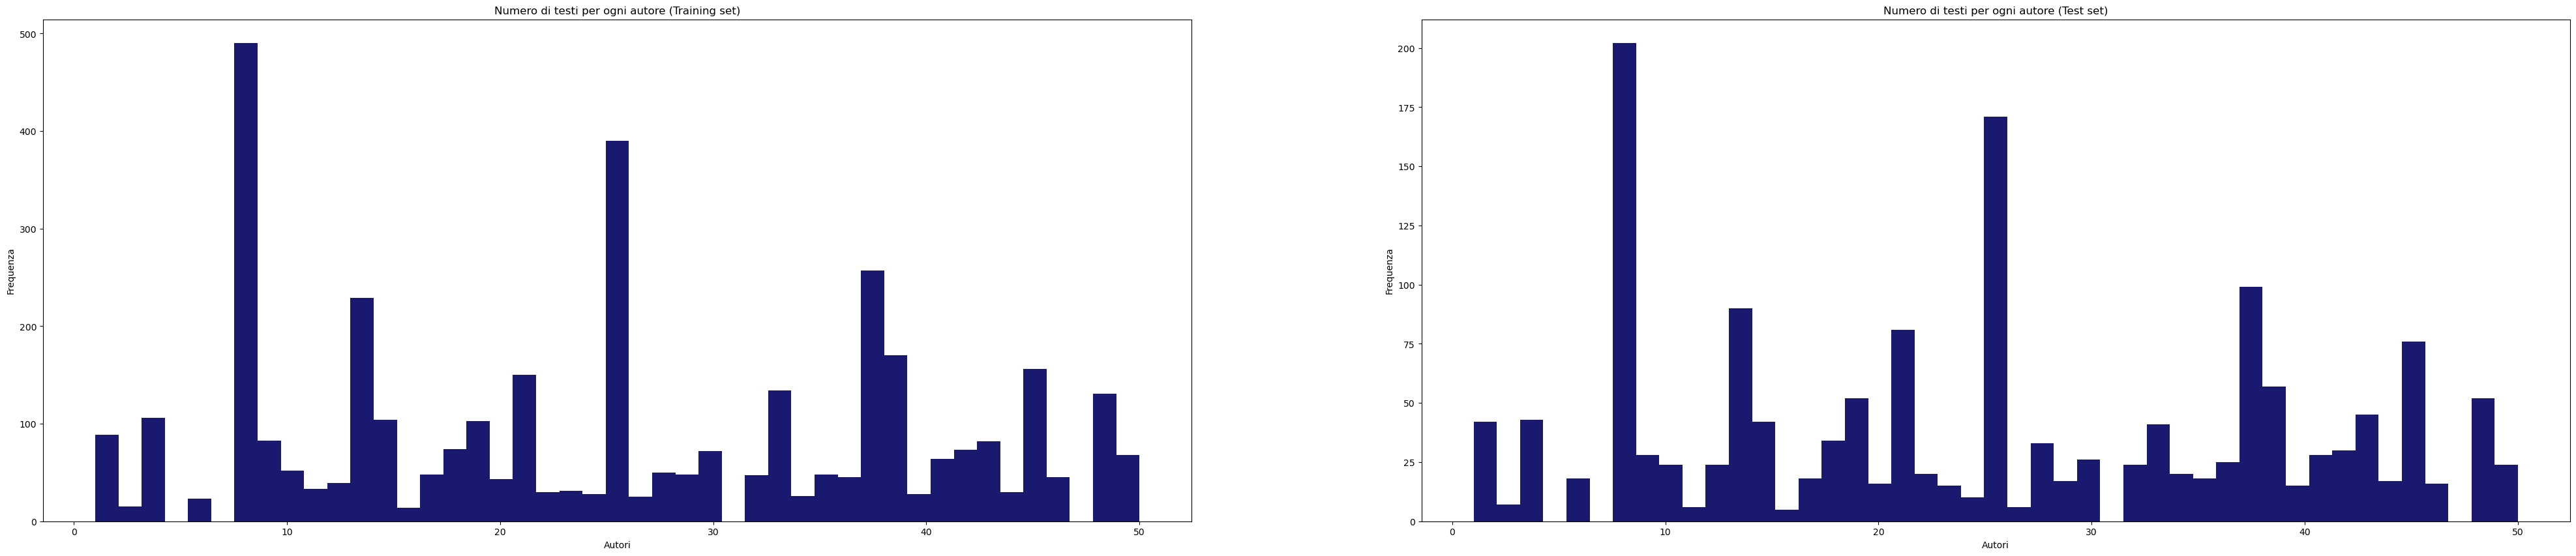

In [102]:
from sklearn.model_selection import train_test_split


small_df     = pd.DataFrame()
percentage   = 0.1
percentage_t = 0.3


# RIDUZIONE DATASET: small_df
for author in classes:
    df_author = df.loc[df.author == author]
    _, small  = train_test_split(df_author, test_size=percentage, random_state=42)
    small_df  = pd.concat([small_df, small])


# ESTRAZIONE DI TRAINING SET E TEST SET
df, dft = train_test_split(small_df, test_size=percentage_t, random_state=20, stratify=None)
display(df)
display(dft)


# ISTOGRAMMI
fig, axes = plt.subplots(1, 2, figsize=(50, 10))
axes[0].hist(df.author.to_numpy(), bins=authors, color='midnightblue')
axes[0].set(xlabel='Autori', ylabel='Frequenza', title='Numero di testi per ogni autore (Training set)')

axes[1].hist(dft.author.to_numpy(), bins=authors, color='midnightblue')
axes[1].set(xlabel='Autori', ylabel='Frequenza', title='Numero di testi per ogni autore (Test set)')

plt.show()


# TRASFORMAZIONE DEL DATA FRAME IN ARRAY
global_corpus = df.text.to_numpy()
test_corpus   = dft.text.to_numpy()



## Preprocessamento dei dati
I testi devono essere trasformati in una _rappresentazione vettoriale_ al fine di essere trattati. Per prima cosa i corpus vengono *lemmatizzati* per raggruppare parole equivalenti (e.g. week e weeks). Successivamente viene creata la rappresentazione vettoriale per ogni testo del dataset che, in questo modo, viene descritto da un vettore di occorrenze di termini.

La rappresentazione scelta utilizza i pesi _tfidf_, un modello "bag od words" che, dunque, perde l'informazione sintattica e semantica delle parole.

In [103]:
# import nltk
# nltk.download('wordnet')
# nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer


# Funzione per la lemmatizzazione di un testo in formato stringa

def lemmatize_text(text, lemmatizer):
    tokens            = text.split()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemmatized_tokens)



# Creazione della distribuzione delle parole per i vari autori

lemmatizer = WordNetLemmatizer()
# Con i parametri max_df e min_df si stanno eliminando dal corpus parole molto frequenti e gli hapax, ovvero parole che
# compaiono una sola volta. Sono entrambe informazioni inutili alla classificazione
vectorizer = TfidfVectorizer(encoding='latin-1', stop_words='english', lowercase=True, max_df=0.9, min_df=2)


lemmatized_data      = [lemmatize_text(text, lemmatizer) for text in global_corpus]
lemmatized_data_test = [lemmatize_text(text, lemmatizer) for text in test_corpus]


X_train = vectorizer.fit_transform(lemmatized_data)
y_train = df.author
X_test  = vectorizer.transform(lemmatized_data_test)
y_test  = dft.author


print(X_train.shape)
print("\nPesi tfidf per il primo documento:\n {}".format(X_train[0]))

(3773, 8427)

Pesi tfidf per il primo documento:
   (0, 5523)	0.03243329276376943
  (0, 4713)	0.038815270660746005
  (0, 8036)	0.04510607923490048
  (0, 5167)	0.08724034818203943
  (0, 4296)	0.03312966785850974
  (0, 426)	0.04565005230683337
  (0, 1487)	0.048761731104218574
  (0, 6818)	0.049640941521326275
  (0, 6297)	0.05568906804870958
  (0, 7000)	0.046134613556416675
  (0, 1321)	0.033207594320744944
  (0, 4817)	0.06229363945977506
  (0, 7751)	0.03172936523883529
  (0, 5792)	0.052757426342464844
  (0, 2039)	0.04742894856791042
  (0, 567)	0.0637477190041989
  (0, 6782)	0.04495464021607622
  (0, 7311)	0.04812637725959305
  (0, 7790)	0.047983949441840264
  (0, 5057)	0.049376292271138926
  (0, 3139)	0.04469368226556933
  (0, 2452)	0.06704070047062846
  (0, 2606)	0.05395714407096597
  (0, 505)	0.04390520776612947
  (0, 1833)	0.04827033933828946
  :	:
  (0, 4394)	0.07370121402305461
  (0, 7141)	0.13833299357443726
  (0, 7164)	0.059903034981822
  (0, 4427)	0.06717619949974621
  (0, 4799)	0.

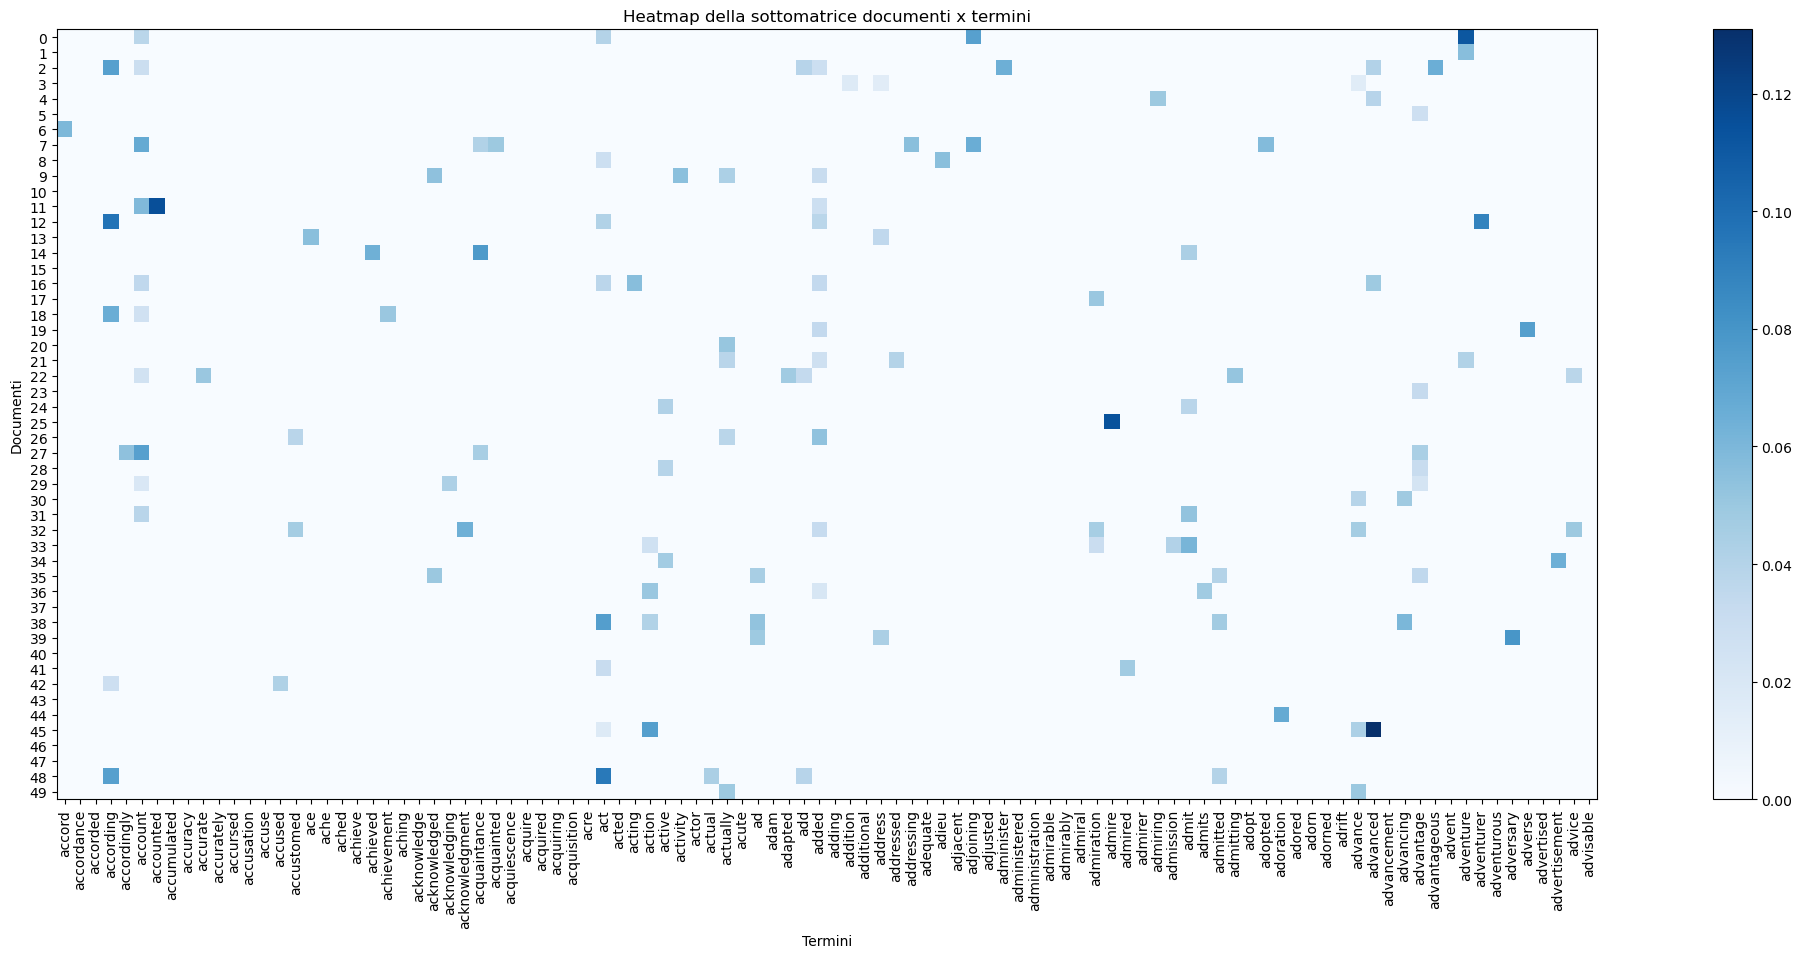

In [104]:
# Stampare una sottomatrice della matrice termini x documenti
num_words = 100
num_docs = 50
start = 60


# Nomi delle feature corrispondenti alle colonne della matrice
feature_names = vectorizer.get_feature_names_out()

# Sottomatrice documenti x termini
sub_matrix = X_train[:num_docs, start:start+num_words].toarray()


# Heatmap della sottomatrice documenti x termini
plt.figure(figsize=(30, 10))
plt.imshow(sub_matrix, cmap=plt.cm.Blues, interpolation='nearest')
plt.colorbar()
plt.xlabel('Termini')
plt.ylabel('Documenti')
plt.title('Heatmap della sottomatrice documenti x termini')
plt.xticks(range(num_words), feature_names[start:start+num_words], rotation='vertical')
plt.yticks(range(num_docs))
plt.show()


***Commenti***:

* Come è possibile notare dalla heatmap, la matrice termini x documenti risulta notevolmente sparsa;
* La lemmatizzazione non ha funzionato a dovere, in quanto riesce a convertire correttamente solo il plurale dei lemmi e non, ad esempio, la coniugazione dei tempi verbali (e.g. _acted_ e _acting_ non vengono convertiti in _act_).

# Riduzione di dimensionalità
Al fine di contenere il problema della dimensionalità, occorre ridurre il numero di features. Tuttavia, non è possibile utilizzare una PCA a causa di una matrice $termini \times documenti$ eccessivamente sparsa. Per i dati testuali esiste una tecnica chiamata LSA (Latent Semantic Analysis): in particolare, sarà utilizzata la Truncated SVD (Singular Value Decomposition) che fornisce la miglior approssimazione della matrice $termini\times documenti$ in $k<n$ dimensioni.

Come prima cosa, si procederà con una decomposizione ai valori singolari della matrice originaria. Infatti, si vuole conoscere la varianza spiegata delle varie componenti (direttamente ottenibile dai valori singolari) per poi scegliere un buon compromesso per k. Una volta selezionato un valore per k si procederà con una Truncated SVD, giungendo alla forma approssimata per la matrice $termini \times documenti$.


creata la SVD
fit fatta


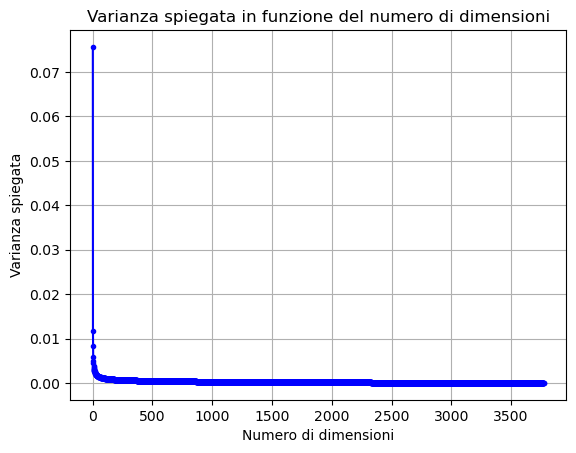

In [72]:
from sklearn.decomposition import TruncatedSVD

num_pc = X_train.shape[1]-1
svd = TruncatedSVD(n_components=num_pc, random_state=42)
print("creata la SVD")
svd.fit(X_train)
print("fit fatta")

# Andamento dei valori singolari e calcolo della varianza spiegata
singular_values = svd.singular_values_
variance_explained = (singular_values ** 2) / np.sum(singular_values ** 2)


# Plot dell'andamento dei valori singolari
plt.plot(np.arange(1, len(singular_values) + 1), variance_explained, 'b.-')
plt.xlabel('Numero di dimensioni')
plt.ylabel('Varianza spiegata')
plt.title('Varianza spiegata in funzione del numero di dimensioni')
plt.grid(True)
plt.show()

***Commenti***:

Si nota che l'andamento della varianza spiegata mostra un 'gomito' tra 0 e 500 features, dunque si sceglie di proseguire con un k = 300, dove k è la dimensionalità ridotta.


In [127]:
# Decomposizione SVD con k=300 dimensioni
k = 300
svd_def = TruncatedSVD(n_components=k, n_iter=7, random_state=42)
svd_def.fit(X_train)

X_transformed = svd_def.transform(X_train)

print("X_transformed shape: {}\n".format(X_transformed.shape))
print("y_train shape      : {}\n".format(y_train.shape))

X_transformed shape: (3773, 300)

y_train shape      : (3773,)



In [128]:
X_train = X_transformed
X_test = svd_def.transform(X_test)
print(type(X_train))

<class 'numpy.ndarray'>


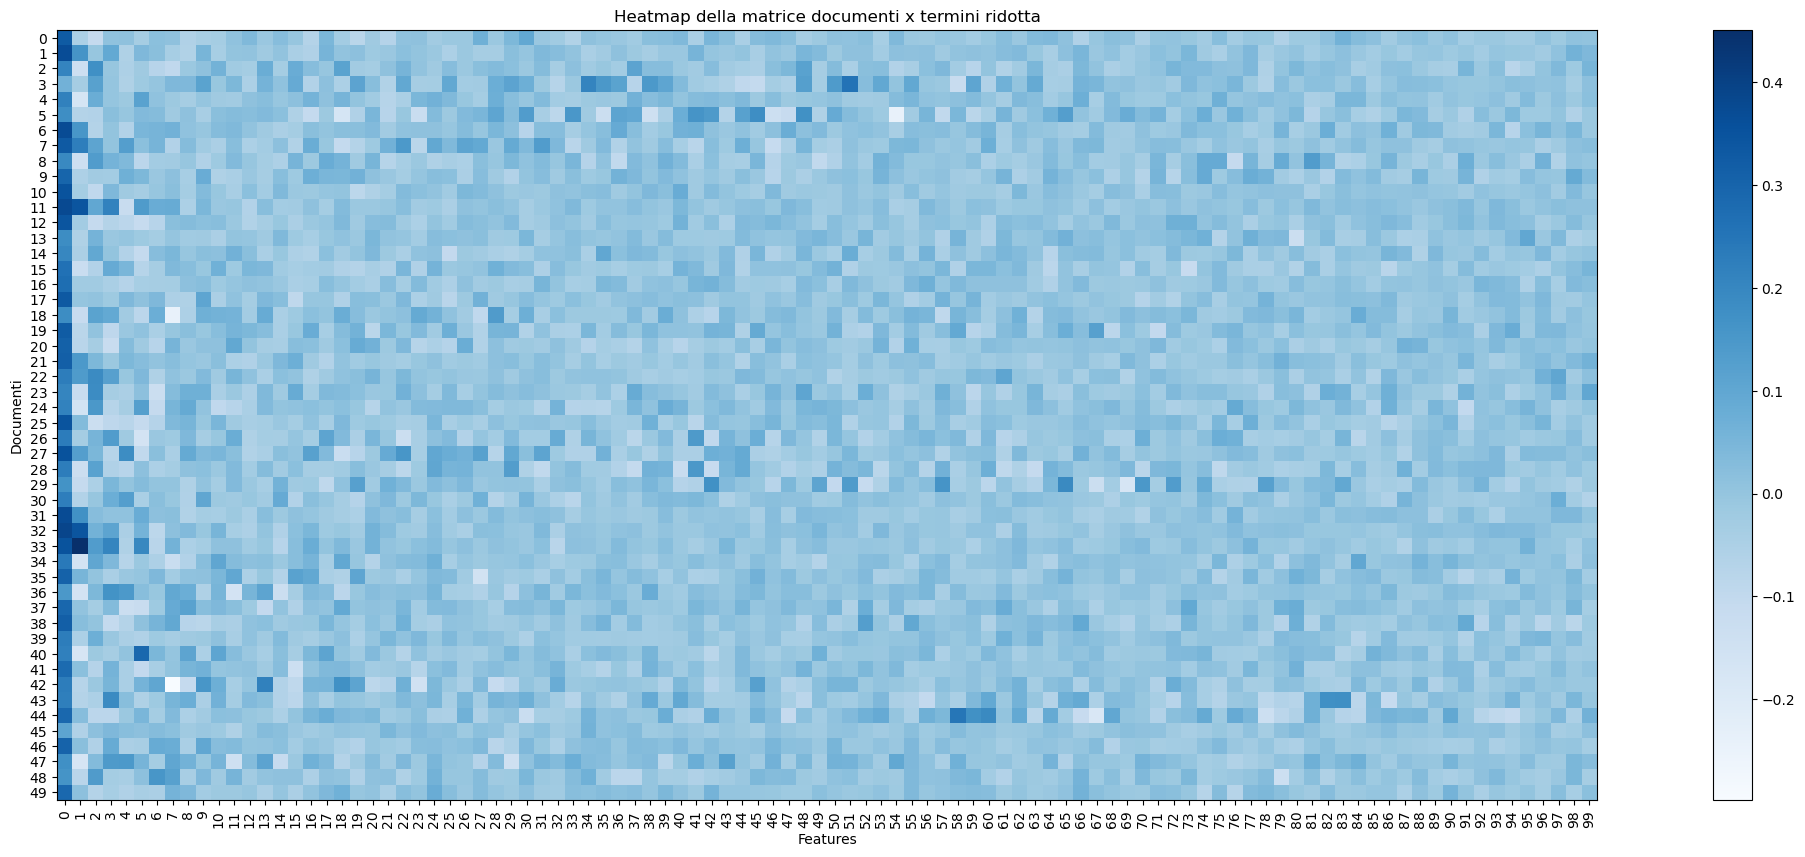

In [129]:
# Stampare una sottomatrice della matrice termini x documenti
num_words = 100
num_docs = 50
start = 0


# Sottomatrice documenti x termini
sub_matrix = X_train[:num_docs, start:start+num_words]#.toarray()


# Heatmap della sottomatrice documenti x termini
plt.figure(figsize=(30, 10))
plt.imshow(sub_matrix, cmap=plt.cm.Blues, interpolation='nearest')
plt.colorbar()
plt.xlabel('Features')
plt.ylabel('Documenti')
plt.title('Heatmap della matrice documenti x termini ridotta')
plt.xticks(range(num_words), range(start,start+num_words), rotation='vertical')
plt.yticks(range(num_docs))
plt.show()

***Commenti***:

Attraverso la procedura, è stata ottenuta una matrice decisamente più densa. Guardando alla heatmap come a un'immagine, nella parte sinistra si può apprezzare maggiormente la differenza tra i "pixel", che invece risultano più omogenei nella parte destra. Questo si spiega grazie alla maggior varianza racchiusa nelle prime componenti.


Questa rappresentazione dei documenti sarà adottata nel resto dello studio.


# SVM
La SVM non converge se le classi non sono linearmente separabili dunque si è scelto di testare questo modello con la variante _soft margin_.
Tale formulazione del problema possiede in funzione obiettivo un termine aggiuntivo che considera il contributo degli errori del modello attraverso le variabili di slack. Questa aggiunta serve per la regolarizzazione e viene pesata attraverso l'iperparamentro C: più decresce più stiamo alleggerendo il peso degli errori dello specifico dataset. Per imparare il miglior valore di C è stata eseguita una cross validation.


La cross validation divide il dataset in k insiemi (fold) e, nelle varie iterazioni, vengono partizionati nel seguente modo: k-1 fold per il training set e 1 fold per il validation set. Ciascuna iterazione produce un risultato di performance. La media delle prestazioni sulle singole iterazioni può essere considerata come una buona stima delle prestazioni su dati futuri del modello allenato su tutto il training set.


Le prestazioni per ciascuna iterazione della cross validation vengono calcolate attraverso la metrica _f-measure_, che computa la media armonica tra la precision e la recall. Questa metrica è il giusto compromesso per valutare la bontà della classificazione. Non si utilizzerà l'accuracy in quanto le classi oggetto di studio sono sbilanciate e produrrebbero valori di accuratezza falsati.

La f-measure è una misura propria della classe, dunque sulle varie matrici di confusione prodotte dalla cross validation occorre combinare le f-measure prodotte dalle diverse classi. Si procederà con una _micro average_, che di fatto calcola le metriche (precision e recall) sulle singole classi e poi ne fa la media.

Mean Scores: [0.7389443251512217, 0.8128941939286769, 0.8391323874082494, 0.8476141355451701, 0.8526476078200217, 0.852116402116402, 0.8560944802324112, 0.854767518560622, 0.8539738677669713, 0.8497340462857705, 0.8513248564972702, 0.8510582010582011, 0.8502624450900311, 0.8507908438942922, 0.8507922473439715, 0.849465987397022, 0.8502624450900311, 0.8505269953545815, 0.8510574993333613]
0.7389443251512217


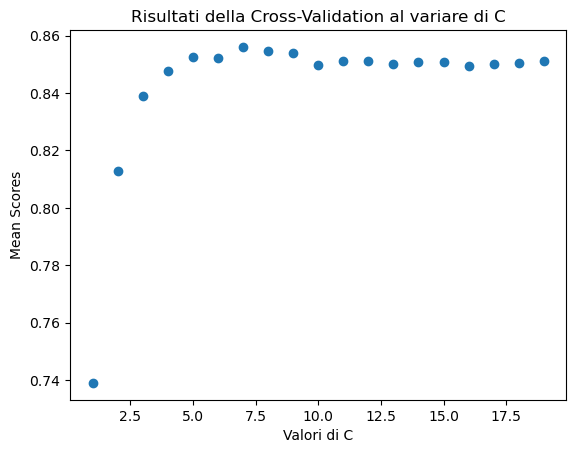

In [134]:
# CROSS VALIDATION PER C

decision_function_shape = 'ovr'
# "one-vs-rest" è la strategia utilizzata per l'estensione della SVM multiclasse. Addestra un classificatore binario per ciascuna classe
# atto a distingue quella classe dalle altre.
max_iter = 100

kernel = "linear"



mean_scores = []
c_values = np.arange(1, 20, 1)

i = 1

for c in c_values:
    
    # stampa la barra per il progresso della cross validation
    progress = i/iterations * 100
    bar = '[' + '=' * int(progress / 10) + '>' + '.' * (10 - int(progress / 10)) + ']'
    print(f'Cross validation in corso: {progress:.1f}% {bar}', end='\r')
    
    svm_model = svm.SVC(C=c, max_iter=100, kernel=kernel, decision_function_shape=decision_function_shape)
    scores = cross_val_score(svm_model, X_train, y_train, cv=10,scoring='f1_micro')
    mean_scores.append(np.mean(scores))
    i = i + 1


print("Mean Scores:", mean_scores)
print(mean_scores[0])
plt.scatter(c_values, mean_scores)
plt.xlabel('Valori di C')
plt.ylabel('Mean Scores')
plt.title('Risultati della Cross-Validation al variare di C')
plt.show()

print("Il miglior valore di C tra quelli analizzati è {}".format(c_values[np.argmax(mean_scores)]))


***Commenti***:

Dato che vogliamo allontaraci dalla soluzione _hard margin_ sono preferiti valori di C più piccoli. Infatti, per $C\to\infty $ il problema _soft margin_ tende a coincidere con quello _hard margin_. Inoltre, il parametro C ha una funzione di regolarizzazione e, in base alla documentazione ufficiale, più è piccolo più è forte il suo contributo.



Si nota ce di proseguire con un iperparametro $C=7$

Report classificazione training set:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00        61
           2       1.00      1.00      1.00        28
           3       1.00      1.00      1.00        15
           4       1.00      0.94      0.97       106
           6       1.00      1.00      1.00        23
           8       0.99      1.00      0.99       490
           9       1.00      1.00      1.00        83
          10       1.00      1.00      1.00        52
          11       1.00      1.00      1.00        33
          12       1.00      1.00      1.00        39
          13       1.00      1.00      1.00        30
          14       0.99      0.99      0.99       199
          15       1.00      1.00      1.00       104
          16       1.00      0.93      0.96        14
          17       1.00      1.00      1.00        48
          18       1.00      1.00      1.00        74
          19       0.97      0.97      0.97

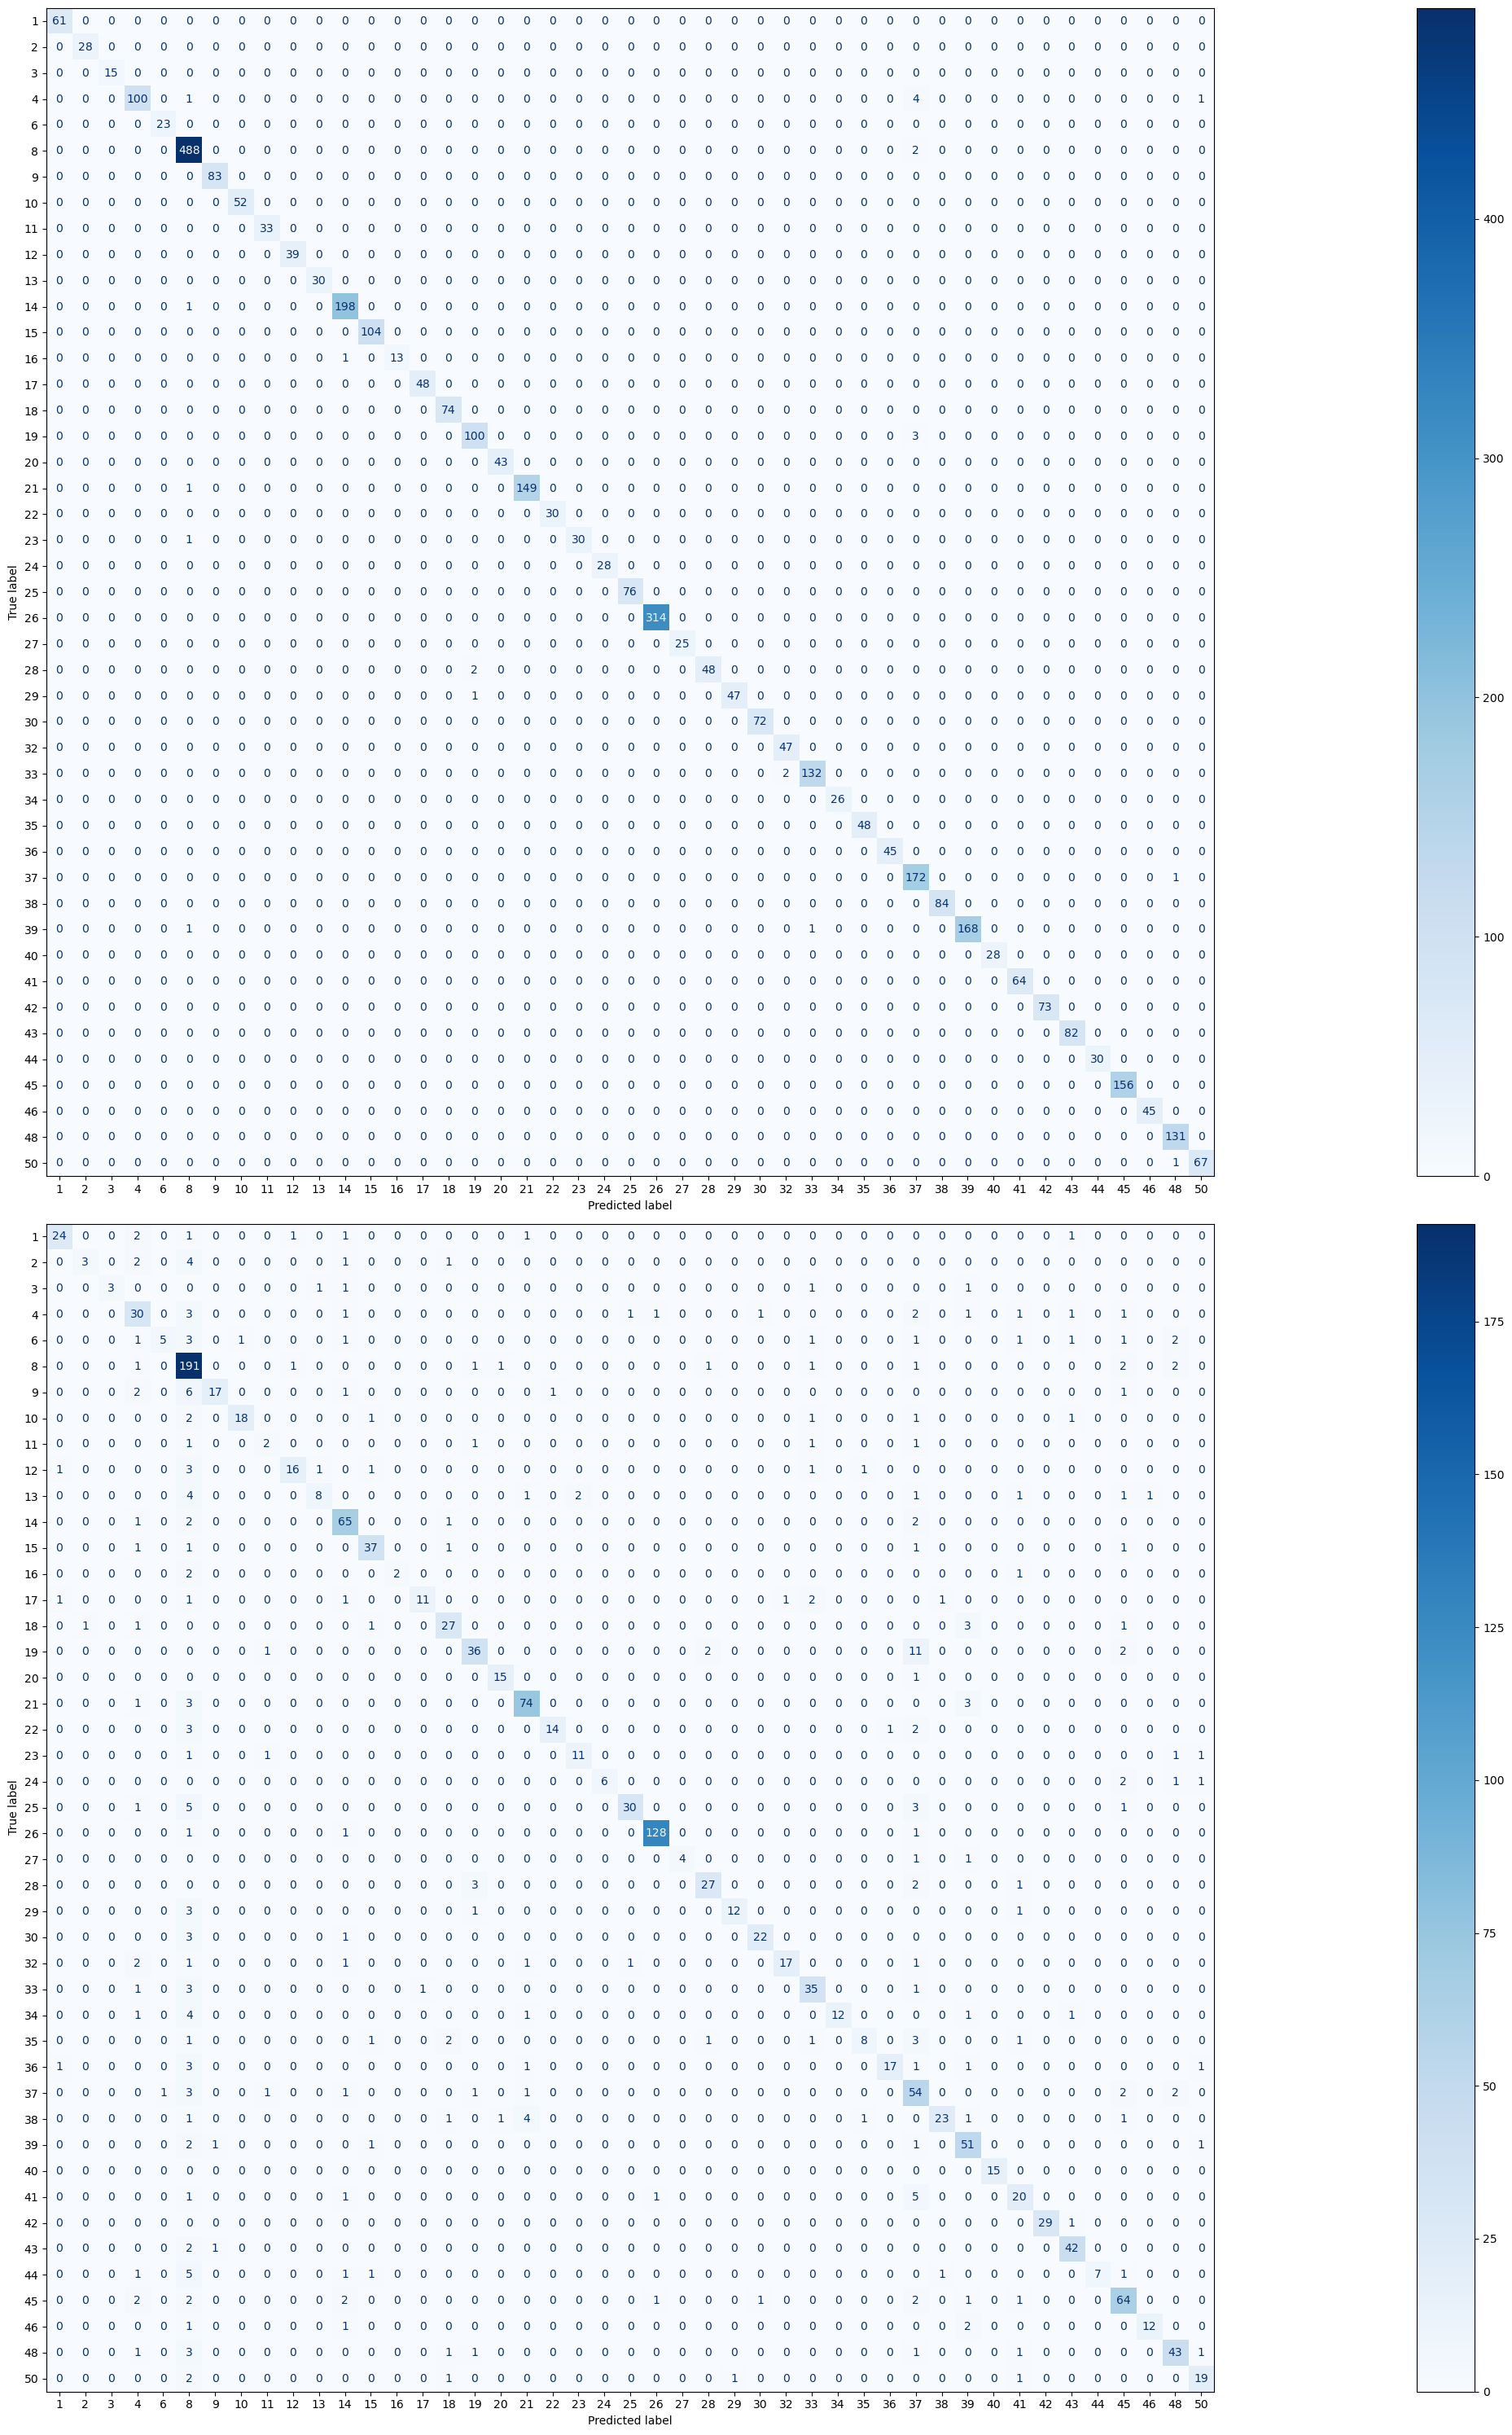

In [138]:
# ADDESTRAMENTO DEL MODELLO FINALE E MATRICE DI CONFUSIONE
import matplotlib.cm as cm

decision_function_shape = 'ovr'
max_iter = 100
c        = 7
kernel = "linear"


svm_model = svm.SVC(C=c, max_iter=max_iter, kernel=kernel, decision_function_shape=decision_function_shape)
svm_model.fit(X_train, y_train)
score     = svm_model.score(X_train, y_train)
score_t   = svm_model.score(X_test, y_test)

predicted   = svm_model.predict(X_train)
predicted_t = svm_model.predict(X_test)
cm_train    = confusion_matrix(y_train, predicted, labels=svm_model.classes_)
report_tr   = classification_report(y_train, predicted, labels=svm_model.classes_)
cm_test     = confusion_matrix(y_test, predicted_t, labels=svm_model.classes_)
report_te   = classification_report(y_test, predicted_t, labels=svm_model.classes_)
print("Report classificazione training set:\n {}\n".format(report_tr))
print("Report classificazione test set:\n {}\n".format(report_te))


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(50, 30))
disp            = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=svm_model.classes_)
disp_t          = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=svm_model.classes_)
disp.plot(ax=ax1, cmap=plt.cm.Blues)
disp_t.plot(ax=ax2, cmap=plt.cm.Blues)



plt.tight_layout()
plt.show()

Per valutare il modello si deve far riferimento alle metriche _micro_ in quanto le classi del dataset risultano sbilanciate. Il report non le stampa perché identiche all'accuracy.

Il modello prodotto mediante le _soft margin SVM_ confonde maggiormente queste due casistiche:
* la classe 19 viene spesso scambiata per la classe 37 (11 errori);
* la classe 9 viene spesso scambiata per la classe 8 (6 errori).

Inoltre, si osserva che il modello sbaglia il più delle volte assegnando la classe 8 a istanze appartenenti ad altre classi. Tale classe è la più numerosa, dunque emerge una sua debolezza nel trattare problemi sbilanciati.

***Commenti***:

Inizialmente, guardando la curva della varianza spiegata in funzione del numero di dimensioni, era stato scelto di ridurre le feature a $k=200$. Tuttavia, è stato osservato che il modello si comportava peggio rispetto alle previsioni della cross validation (accuratezza attesa $\sim 0.83$, accuratezza ottenuta $\sim 0.79$). Per cercare di migliorare il modello, sono state testate varie riduzioni di dimensionalità e diversi coefficienti di regolarizzazione C nell'intorno dei valori inizialmente considerati. 

Fissando il valore di $C=8$:
* il modello senza riduzione di feature presenta accuratezza nel test set di $\sim 0.83$
* il modello con 500 feature presenta accuratezza nel test set di $\sim 0.82$
* il modello con 300 feature presenta accuratezza nel test set di $\sim 0.81$
* il modello con 200 feature presenta accuratezza nel test set di $\sim 0.79$

Fissando il numero di feature a $k=500$:
* il modello con $C=8$ presenta accuratezza nel test set di $\sim0.82$
* il modello con n $C=7$ presenta accuratezza nel test set di $\sim 0.82$
* il modello con n $C=5$ presenta accuratezza nel test set di $\sim 0.82$

In virtù di questi risultati e tenendo conto della forma della varianza spiegata, si è stabilito di riformulare la riduzione di dimensionalità fissando $k=300$. In questo modo si nota come le performance (riportate nei report precendenti) siano nettamente più vicine a quelle ottenute con $k=500$, pur "risparmiando" duecento features rispetto a questo ultimo caso.

# SOFTMAX REGRESSION

Il secondo modello considerato rappresenta l'estensione multiclasse della regressione logistica. Si tratta di un modello discriminativo che non acquisisce conoscenza su come sono fatte le classi come i modelli generativi, ma risulta più robusto e semplice rispetto a questi ultimi.

La softmax regression modella la probabilità del dataset attraverso una distribuzione categorica il cui parametro $p_{ij} = p(C_j|\textbf{x}_i) = s(\textbf{w}\cdot \textbf{x}_i)$, ovvero viene calcolato grazie alla funzione _softmax_.

Restituisce un valore di probabilità per ciascuna classe. Per scegliere la classe predetta si prenderà la classe $C_{h}$ tale che $h=\arg\max_{j=1,...,k} P(C_{j}|\textbf{x}_{i})$.

Cross validation in corso: 100.0% [==========>]
Mean Scores: [0.6133131236579512, 0.7892993979200875, 0.823222180118732, 0.8343529395253533, 0.8425680322232048, 0.8465454086143742, 0.8510532889843235, 0.852112893492204, 0.8550271567512947, 0.8560881647088543, 0.856354118423084, 0.8579449286345838, 0.856883920677024, 0.8568846224018637, 0.856883920677024, 0.8574137229309644, 0.8566186686876343, 0.8579442269097441, 0.857414424655804, 0.8576789749203542]
0.6133131236579512


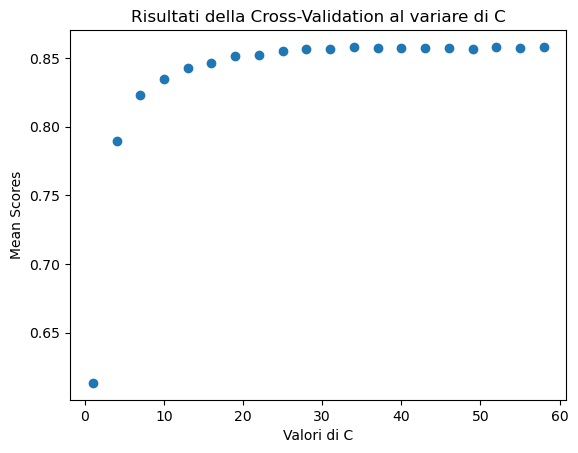

Il miglior valore di C tra quelli analizzati è 34


In [130]:
#CROSS VALIDATION PER IPERPARAMETRO DI REGOLARIZZAZIONE C

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif


# L'algoritmo che viene usato per il problema di ottimizzazione è ‘lbfgs’, in grado di gestire la loss multinomiale


mean_scores_s = []
c_values_s    = np.arange(1, 60, 3)
iterations    = len(c_values_s)
i = 1

for c in c_values_s:

    # stampa la barra per il progresso della cross validation
    progress = i/iterations * 100
    bar = '[' + '=' * int(progress / 10) + '>' + '.' * (10 - int(progress / 10)) + ']'
    print(f'Cross validation in corso: {progress:.1f}% {bar}', end='\r')

    softmax_model = LogisticRegression(C=c)
    scores = cross_val_score(softmax_model, X_train, y_train, cv=10,scoring='f1_micro')
    mean_scores_s.append(np.mean(scores))
    i = i + 1



print("\nMean Scores:", mean_scores_s)
print(mean_scores_s[0])
plt.scatter(c_values_s, mean_scores_s)
plt.xlabel('Valori di C')
plt.ylabel('Mean Scores')
plt.title('Risultati della Cross-Validation al variare di C')
plt.show()

print("Il miglior valore di C tra quelli analizzati è {}".format(c_values_s[np.argmax(mean_scores_s)]))

Report classificazione training set:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00        61
           2       1.00      1.00      1.00        28
           3       1.00      1.00      1.00        15
           4       0.99      0.94      0.97       106
           6       1.00      1.00      1.00        23
           8       0.99      1.00      0.99       490
           9       1.00      1.00      1.00        83
          10       1.00      1.00      1.00        52
          11       1.00      1.00      1.00        33
          12       1.00      1.00      1.00        39
          13       1.00      1.00      1.00        30
          14       1.00      1.00      1.00       199
          15       1.00      1.00      1.00       104
          16       1.00      0.93      0.96        14
          17       1.00      1.00      1.00        48
          18       1.00      1.00      1.00        74
          19       1.00      0.99      1.00

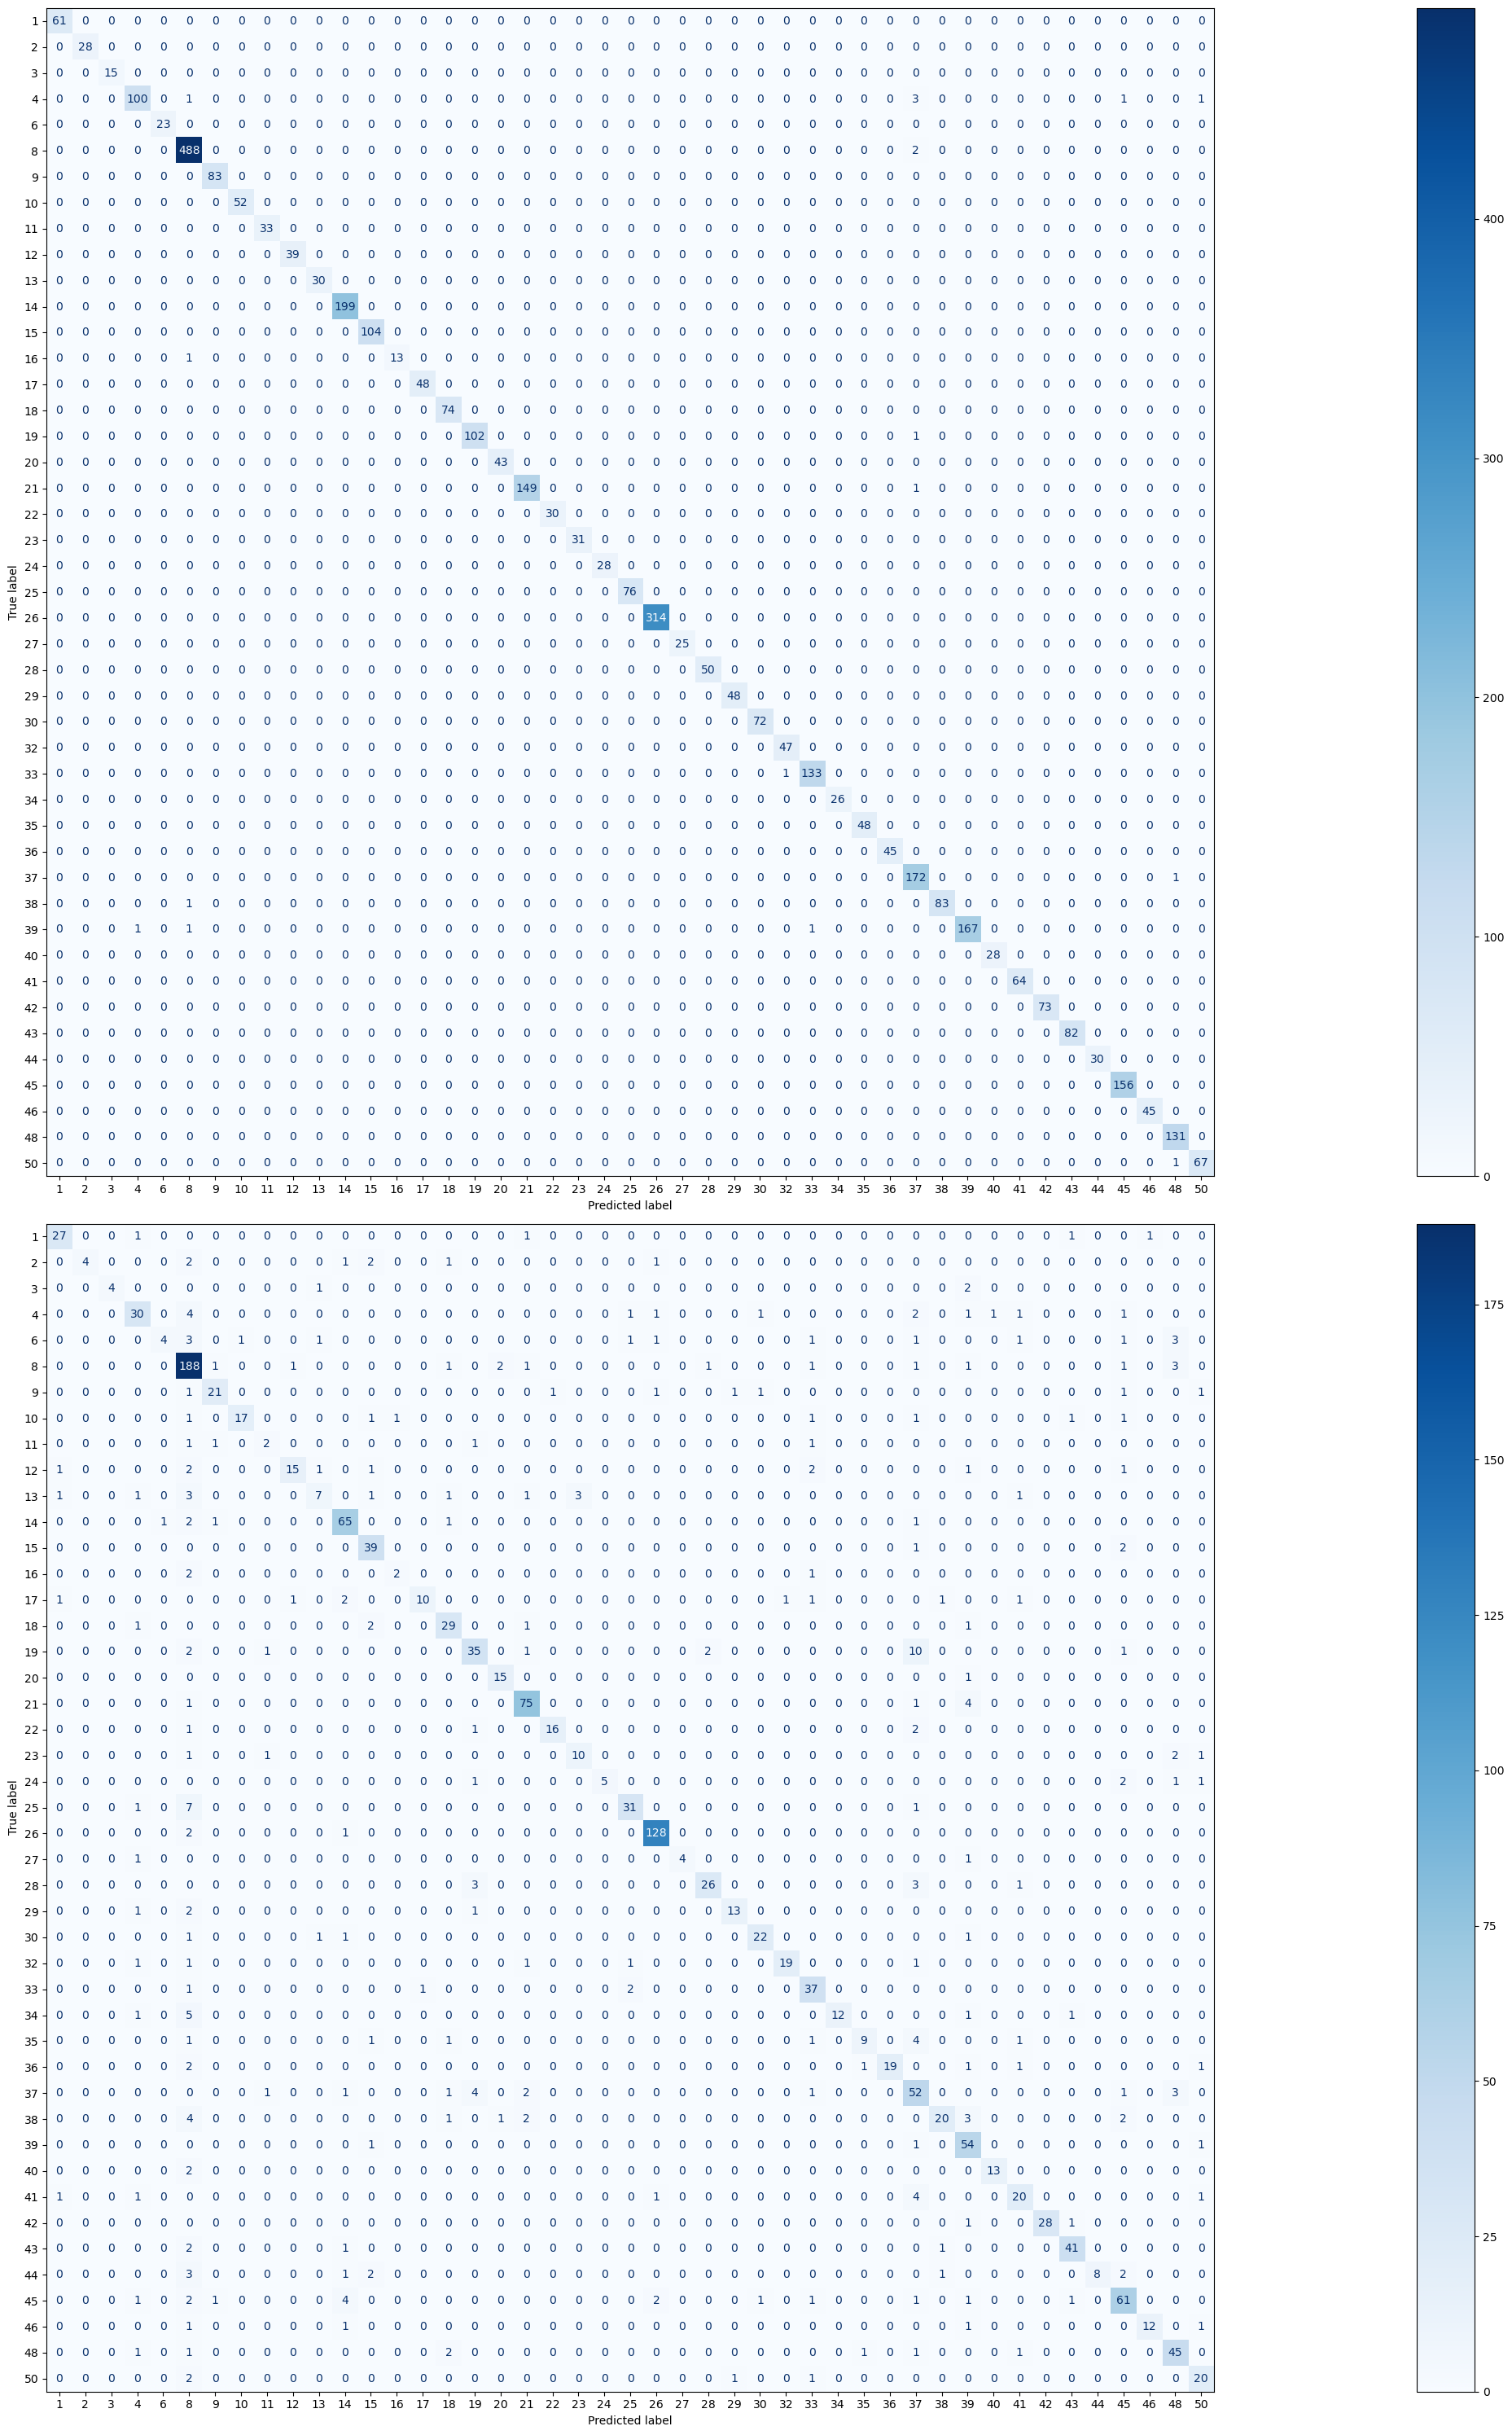

In [133]:
C_s = 34
softmax = LogisticRegression(C=C_s)
softmax.fit(X_train, y_train)


# score_s   = softmax.score(X_train, y_train)
# score_t_s = softmax.score(X_test, y_test)
# print("score train {} - score test {}\n".format(score, score_t))


# la classe predetta da softmax.predict() è ottenuta facendo l'argmax tra le probabilità predette per le varie classi
predicted_s     = softmax.predict(X_train)
predicted_t_s   = softmax.predict(X_test)
cm_train_s      = confusion_matrix(y_train, predicted_s, labels=softmax.classes_)
report_tr_s     = classification_report(y_train, predicted_s, labels=softmax.classes_)
cm_test_s       = confusion_matrix(y_test, predicted_t_s, labels=softmax.classes_)
report_te_s     = classification_report(y_test, predicted_t_s, labels=softmax.classes_)
print("Report classificazione training set:\n {}\n".format(report_tr_s))
print("Report classificazione test set:\n {}\n".format(report_te_s))


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(50, 30))
disp            = ConfusionMatrixDisplay(confusion_matrix=cm_train_s, display_labels=softmax.classes_)
disp_t          = ConfusionMatrixDisplay(confusion_matrix=cm_test_s, display_labels=softmax.classes_)
disp.plot(ax=ax1, cmap=plt.cm.Blues)
disp_t.plot(ax=ax2, cmap=plt.cm.Blues)



plt.tight_layout()
plt.show()

Dalla matrice di confusione si osservano errori analoghi al modello precedente: 
* la classe 19 viene spesso scambiata per la classe 37 (10 errori);
* la classe 25 viene spesso scambiata per la classe 8 (7 errori) e, in generale, il modello sbaglia il più delle volte assegnando la classe 8 a istanze appartenenti ad altre classi.

Le performance, dunque, sono analoghe al modello _soft margin SVM_, sia in termini di valori assoluti che di tipologia di errori commessi. Molto probabilmente, essendo un pattern ricorrente, le classi 19 e 25 risultano essere particolarmente simili ma per concluderlo è necessario uno studio più accurato delle due classi. Per quanto riguarda il secondo punto di debolezza, la causa è insita nel mancato bilanciamento del problema, dunque servirebbe un modello più robusto su questo punto.

# NAIVE BAYES

In [91]:
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB(alpha=1.0e-9)
clf.fit(X_train, y_train.ravel())

ValueError: Negative values in data passed to MultinomialNB (input X)

Grafici per Prior $p(C_i)$, Likelihood $p(t_j|C_i)$, Evidenza $p(t_j)$ e Posterior $p(C_i|t_j)$

In [92]:
# distribuzione a priori e likelihood p(t_j|C_i)
prior=np.exp(clf.class_log_prior_)
lik=np.exp(clf.feature_log_prob_)

# calcolo dell'evidenza
def sumAllClasses(t_i):
    sum = 0
    for c_k in range(0,authors):
        sum += lik[c_k,t_i]*prior[c_k]
    return sum

evid=np.array(
    [sumAllClasses(term_i) for term_i in range(lik.shape[1])]
    )
print(lik.shape)
print(evid.shape)

# da graficare, da calcolare posterior


AttributeError: 'MultinomialNB' object has no attribute 'class_log_prior_'

Calcolo dell'accuracy sul test set, ho fatto un plot di prova, può essere tolto che non ha molto senso

Accuracy = 0.4353827


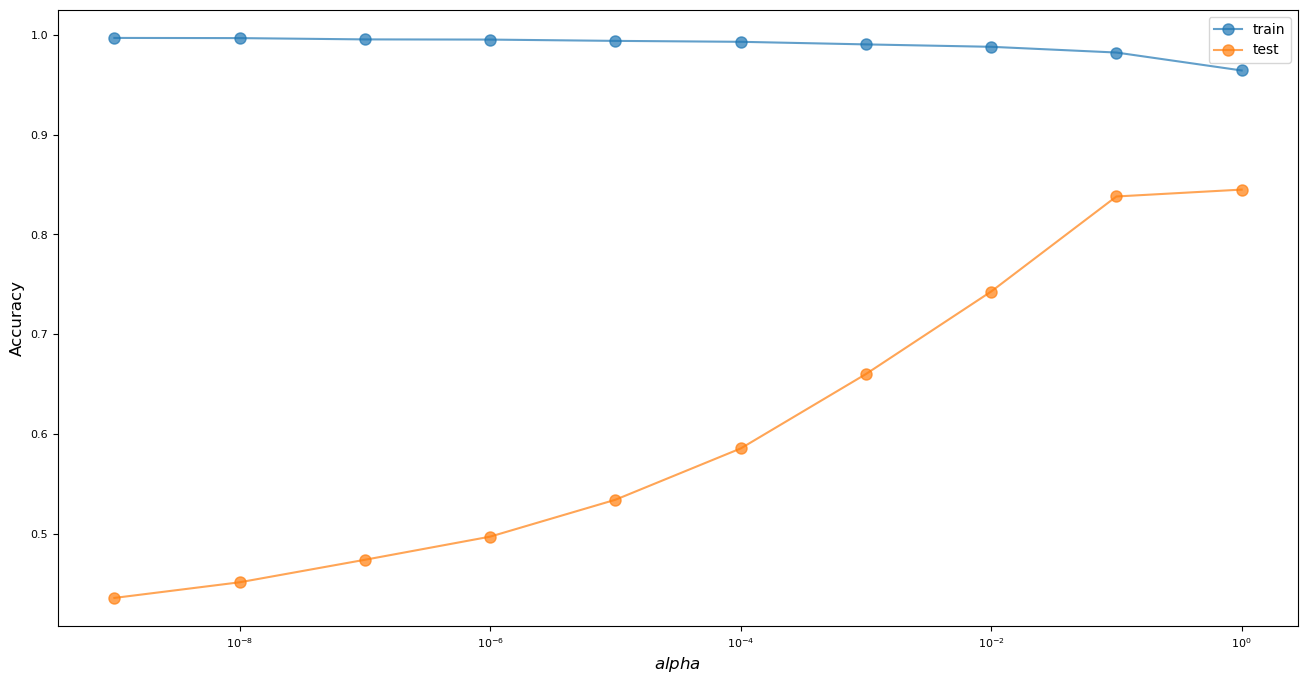

In [ ]:
preds = clf.predict(X_test)
print('Accuracy = {0:8.7f}'.format(accuracy_score(y_test, preds)))

alphas = [1.0e-9, 1.0e-8, 1.0e-7, 1.0e-6, 1.0e-5, 1.0e-4, 1.0e-3, 1.0e-2, 1.0e-1, 1.0]
train_errs = []
test_errs = []
for a in alphas:
    clf = MultinomialNB(alpha=a)
    clf.fit(X_train, y_train.ravel())
    preds_train = clf.predict(X_train)
    preds_test  = clf.predict(X_test)
    train_errs.append(accuracy_score(y_train, preds_train))
    test_errs.append(accuracy_score(y_test, preds_test))

fig = plt.figure(figsize=(16,8))
ax = fig.gca()
plt.tick_params(axis='both', which='major', labelsize=8)
ax.plot(alphas, train_errs, '-o', markersize=8, alpha=.7, label='train')
ax.plot(alphas, test_errs, '-o', markersize=8, alpha=.7, label='test')
plt.legend(fontsize=10)
plt.xlabel('$alpha$', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.xscale("log")
plt.show()

[0.4035250463821892, 0.41929499072356213, 0.4346938775510204, 0.45862708719851575, 0.48515769944341375, 0.5280148423005565, 0.5853432282003711, 0.6799628942486085, 0.79721706864564, 0.7946196660482375]


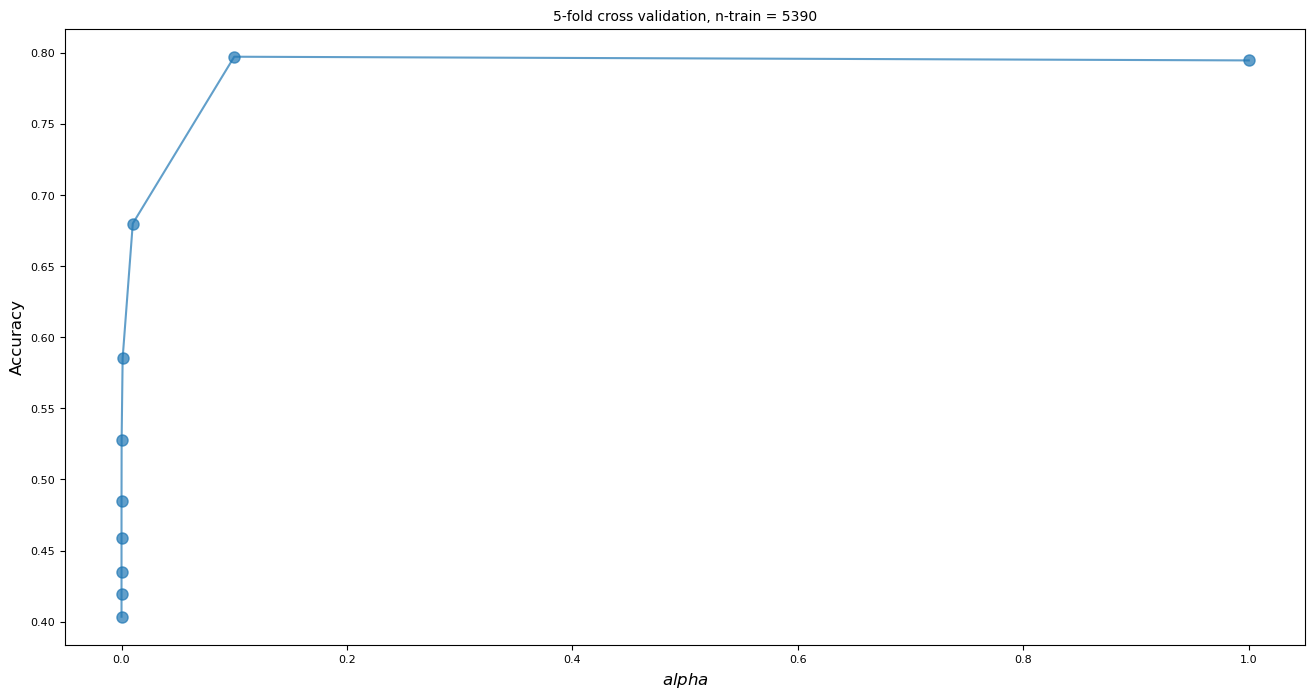

In [ ]:
alphas = [1.0e-9, 1.0e-8, 1.0e-7, 1.0e-6, 1.0e-5, 1.0e-4, 1.0e-3, 1.0e-2, 1.0e-1, 1.0]
scores = []
c = 5

for a in alphas:
    clf = MultinomialNB(alpha=a)
    score = cross_val_score(clf, X_train, y_train, cv=c)
    scores.append(score.mean())

print(scores)

fig = plt.figure(figsize=(16,8))
ax = fig.gca()
plt.tick_params(axis='both', which='major', labelsize=8)
plt.plot(alphas, scores, 'o-', markersize=8, alpha=.7)
# max_k = clf[np.argmax(scores)]
# plt.plot([max_k, max_k], [0, 1.0], color=colors[1])
plt.xlabel('$alpha$', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('{0:d}-fold cross validation, n-train = {1:d}'.format(c,X_train.shape[0]), fontsize=10)
plt.show()
